Each task that is proposed to be completed as part of the homework has a declared "price" in points. The maximum possible amount is 10 points, and together with the bonus assignment - 12 points. It is not necessary to complete all the tasks, only a part can be done. Most of the points expect you to write working Python code; sometimes you will need to write comments - for example, to compare several approaches to solve the same problem. Also you can add more cells for your convenience if you need.

This homework focuses on clustering. We will work with images of handwritten digits, learn how to cluster them using two different methods (hierarchical clustering and the 𝐾-means algorithm), evaluate the quality of the partition and choose the optimal number of clusters, as well as visualize intermediate results.

In [39]:
# make sure you have tqdm
! pip install tqdm

In [40]:
# default imports
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

# styling
from tqdm.notebook import tqdm, trange

%matplotlib inline
%config InlineBackend.figure_formats = ['retina']
plt.style.use('seaborn-darkgrid')

# future warnings
# import warnings filter
from warnings import simplefilter
# ignore all future warnings
simplefilter(action='ignore', category=FutureWarning)

## 1. Loading data
The data we will be working with is available in the scikit-learn library (`sklearn` module) in the `datasets` submodule via the `load_digits` function. The data contains 1,797 observations, each of which is 8×8 pixel image of a handwritten digit from 0 to 9. This is about the same amount of each digit (about 180).

For convenience, every image expands to a 64 (8×8) row, so entire numpy array is 1797×64. The color intensity in each pixel is encoded with an integer from 0 to 16.

In addition to images, their labels are also known. In this task, we will assume that the labels (as well as their amount) are unknown and try to group the data in such a way that the resulting clusters 'better match' the original ones. Possible options for determining the 'better match' are presented later.

**(0.25 points)** Load the images into `X` variable, and their labels into `y` variable.

In [41]:
from sklearn.datasets import load_digits

digits = load_digits()

X = digits.data
y = digits.target

In [42]:
assert X.shape == (1797, 64)
assert y.shape == (1797,)

**(0.5 points)** Visualize the first 10 images.

- Arrange images on a grid rather than in a row. You may need the `subplot` and `imshow` functions from the `pyplot` module in the `matplotlib` library.
- You will also need to reshape the images to 8×8.
- Remove ticks and labels from both axes. The `xticks` and `yticks` functions or the `tick_params` function from `pyplot` can help you with this.
- Make the output good sized with the `figure` function from `pyplot`.

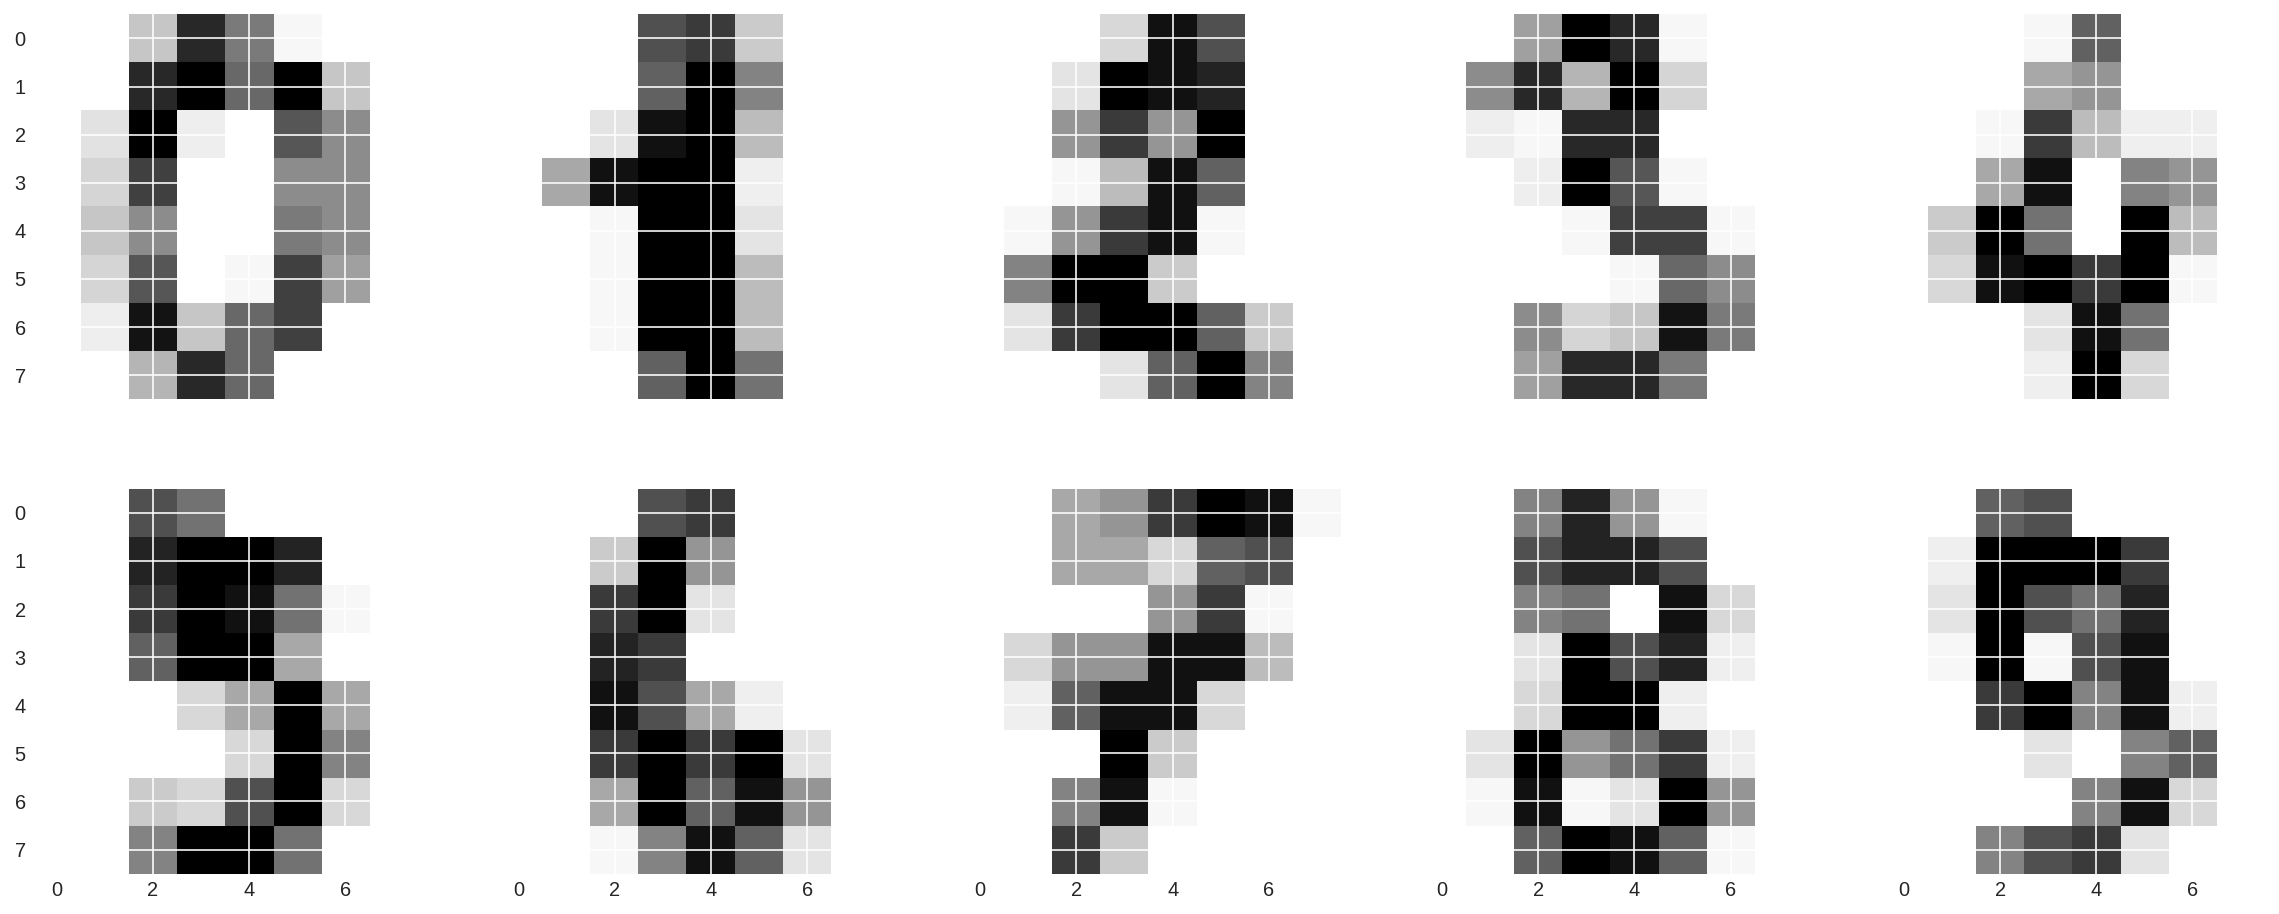

In [43]:
rows, cols, size = 2, 5, 4
fig, ax = plt.subplots(rows, cols, sharex='col', sharey='row', figsize=(cols * size, rows * size))

for i in range(rows * cols):
    ax[i // cols, i % cols].imshow(X[i].reshape((8,8)))

## 2. Clustering and quality evaluation

**(2 points)** Implement the the KMeans algorithm. Use objective function $L = \sum_{i=1}^{n}|x_{i}-Z_{A(x_{i})}|^{2}$, where $Z_{A(x_{i})}$ is the center of the cluster corresponding to $x_{i}$ object.

In [44]:
from sklearn.exceptions import NotFittedError
from numpy.random import RandomState

In [45]:
from numpy.random.mtrand import random_sample
class CustomKMeans:
    def __init__(self, n_clusters=2, max_iter=30, n_init=10, random_state=42):
        '''K-Means clustering.
        
        Args:
            n_clusters: int, default=2
                The number of clusters to be formed is also 
                the number of centroids to generate. 
            max_iter: int, default=300
                Maximum number of iterations of the k-means algorithm for a
                single run.
            n_init: int, default=10
                Number of time the k-means algorithm will be run with different
                centroid seeds. The final results will be the best output of
                n_init consecutive runs in terms of objective function.
            random_state: int, default=42
                Random state.
        '''
        self.n_clusters = n_clusters
        self.n_init = n_init
        self.max_iter = max_iter
        self.random_state = RandomState(seed=random_state)

    def calculate_distances_to_centroids(self, X, cluster_centers):
        """
        Returns (n, c) matrix where the element at position (i, j) 
        is the distance from i-th object to j-th centroid."""
        
        diff = X - cluster_centers[:, np.newaxis]
        return np.sum(diff**2, axis=-1).T 
    
    def update_centroids(self, X, nearest_clusters):
        """
        Returns numpy array of shape (n_clusters, n_features) - 
        new clusters that are found by averaging objects belonging 
        to the corresponding cluster."""
        
        # index for data sorted by clusters
        idx = nearest_clusters.argsort()

        # indexes for spliting sorted data into clusters
        splits = np.unique(nearest_clusters[idx], return_index=True)[1][1:]

        # split sorted data and create centroids
        clusters = np.split(X[idx], splits)
        centroids = [np.mean(cluster, axis=0) for cluster in clusters]
        
        return np.array(centroids)

    def init_random_centroids(self, X, n):
        """ 
        Return n randomly chosen centroids from X."""
        centroids_ids = self.random_state.choice(X.shape[0], n)
        return X[centroids_ids]  

    def fit(self, X):
        """Fit the model.
        
        Args:
            X: numpy array of shape (n_samples, n_features)
        """
        assert X.shape[0] >= self.n_clusters

        self.best_objective_ = None # keep track the best cluster division
        self.objectives_ = []       # keep track the history of objectives

        for epoch in range(self.n_init):
            # select initial centroids randomly and assign points to them randomly
            centroids = self.init_random_centroids(X, self.n_clusters)

            for iter in range(self.max_iter):
                distances = self.calculate_distances_to_centroids(X, centroids)    
                nearest_clusters = distances.argsort()[:,0] # reselect clusters
                updated_centroids = self.update_centroids(X, nearest_clusters)
                
                # if some of our clusters dissapeared in the proccess - restore randomly
                if updated_centroids.shape[0] < self.n_clusters:
                    n = self.n_clusters - updated_centroids.shape[0]
                    additional_centroids = self.init_random_centroids(X, n)
                    updated_centroids = np.append(updated_centroids, additional_centroids, axis=0)

                # break if no changes to clusters made
                if np.allclose(updated_centroids, centroids):
                    break

                centroids = updated_centroids
                

            # check & save objective function and save centroids if it's improved
            objective = np.sum((X - centroids[nearest_clusters])**2)
            self.objectives_.append(objective)
            
            if self.best_objective_ is None or objective < self.best_objective_:
                self.best_objective_ = objective
                self.cluster_centers_ = centroids
            
        return self
            
    
    def predict(self, X):
        """Predict classes.
        
        Args:
            X: numpy array of shape (n_samples, n_features)
        Returns:
            y: numpy array of shape (n_samples,)
                Vector containing predicted cluster labels.
        """
        if hasattr(self, 'cluster_centers_'):
            distances = self.calculate_distances_to_centroids(X, self.cluster_centers_)
            return distances.argsort()[:,0] # select appropriate cluster id
        else: 
            raise NotFittedError("CustomKMeans instance is not fitted yet")


**(1 points)** Get the `X` array partition into 10 clusters. Visualize the centers of clusters.
- We will assume that the center of the cluster is average value of all observations belonging to the cluster.
- The cluster centers should have the same shape as our observations (64). So you have to average the points across the rows.

In [46]:
kmeans = CustomKMeans(n_clusters=10).fit(X)
custom_kmeans_labels = kmeans.predict(X)
assert custom_kmeans_labels.shape == (1797,)

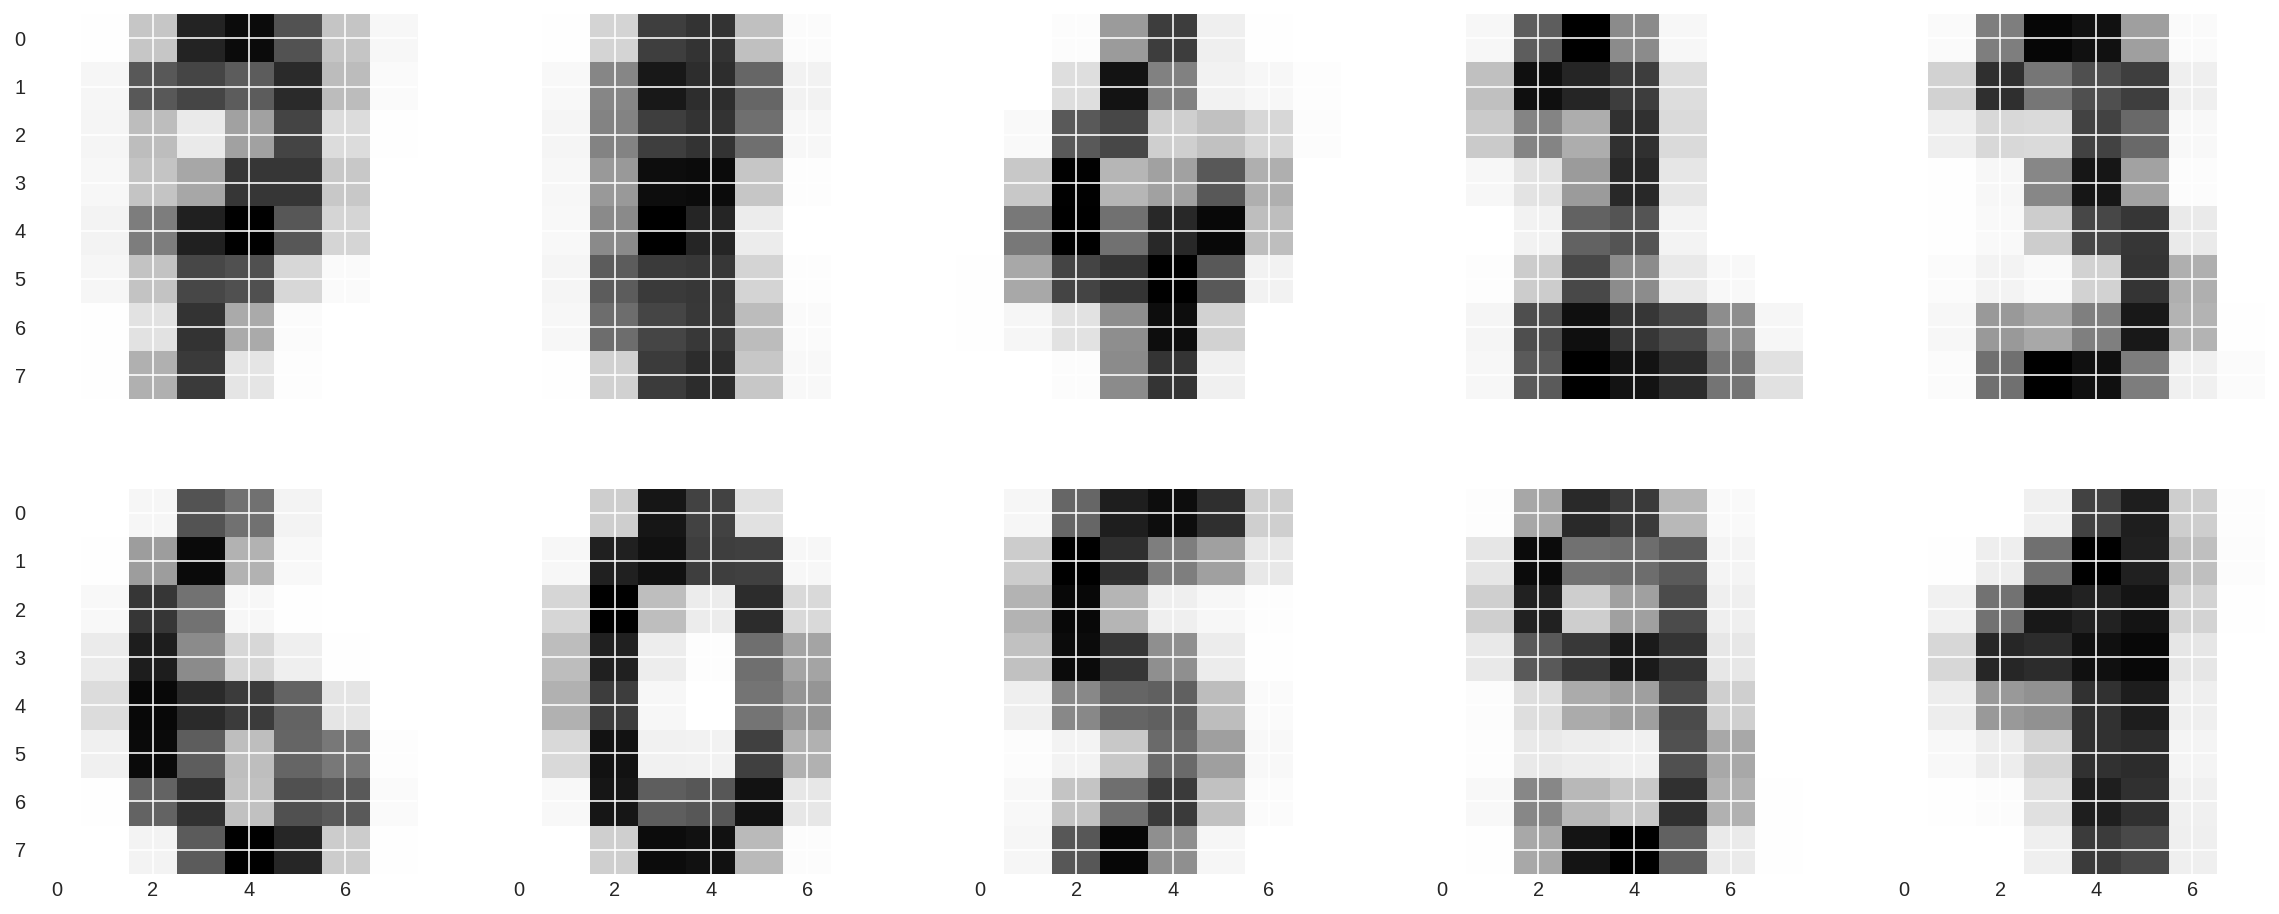

In [47]:
# we can use `CustomKMeans.cluster_centers_` attribute
# but to make sure we can recheck and assert

def clusters_mean(X, labels):
    """
    Return mean of X for each label."""

    # the code below is the copy of method I've used in the class itself
    idx = labels.argsort()
    splits = np.unique(labels[idx], return_index=True)[1][1:]
    clusters = np.split(X[idx], splits)
    
    return [np.mean(cluster, axis=0) for cluster in clusters]

centroids = clusters_mean(X, custom_kmeans_labels)

assert np.allclose(kmeans.cluster_centers_, centroids)

rows, cols, size = 2, 5, 4
fig, ax = plt.subplots(rows, cols, sharex='col', sharey='row', figsize=(cols * size, rows * size))

for i in range(rows * cols):
    ax[i // cols, i % cols].imshow(centroids[i].reshape((8,8)))

**(0.5 points)** Experiment with `max_iter` and `n_init` parameters. Look at the range of values of the objective function, it's best values, at what parameters and how often they are achieved.

In [48]:
max_iters = [1, 2, 4, 6, 8, 10, 15, 30, 50, 100]
n_inits = [1, 2, 4, 6, 8, 10, 15, 30, 50, 100]

mins = []
ranges = []

for max_iter in tqdm(max_iters):
    mins.append([])
    ranges.append([])

    for n_init in tqdm(n_inits, leave=False):
        objectives = CustomKMeans(n_clusters=10, max_iter=max_iter, n_init=n_init).fit(X).objectives_
        
        min_objective = min(objectives)
        range_objective = max(objectives) - min_objective

        mins[-1].append(min_objective)
        ranges[-1].append(range_objective)

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

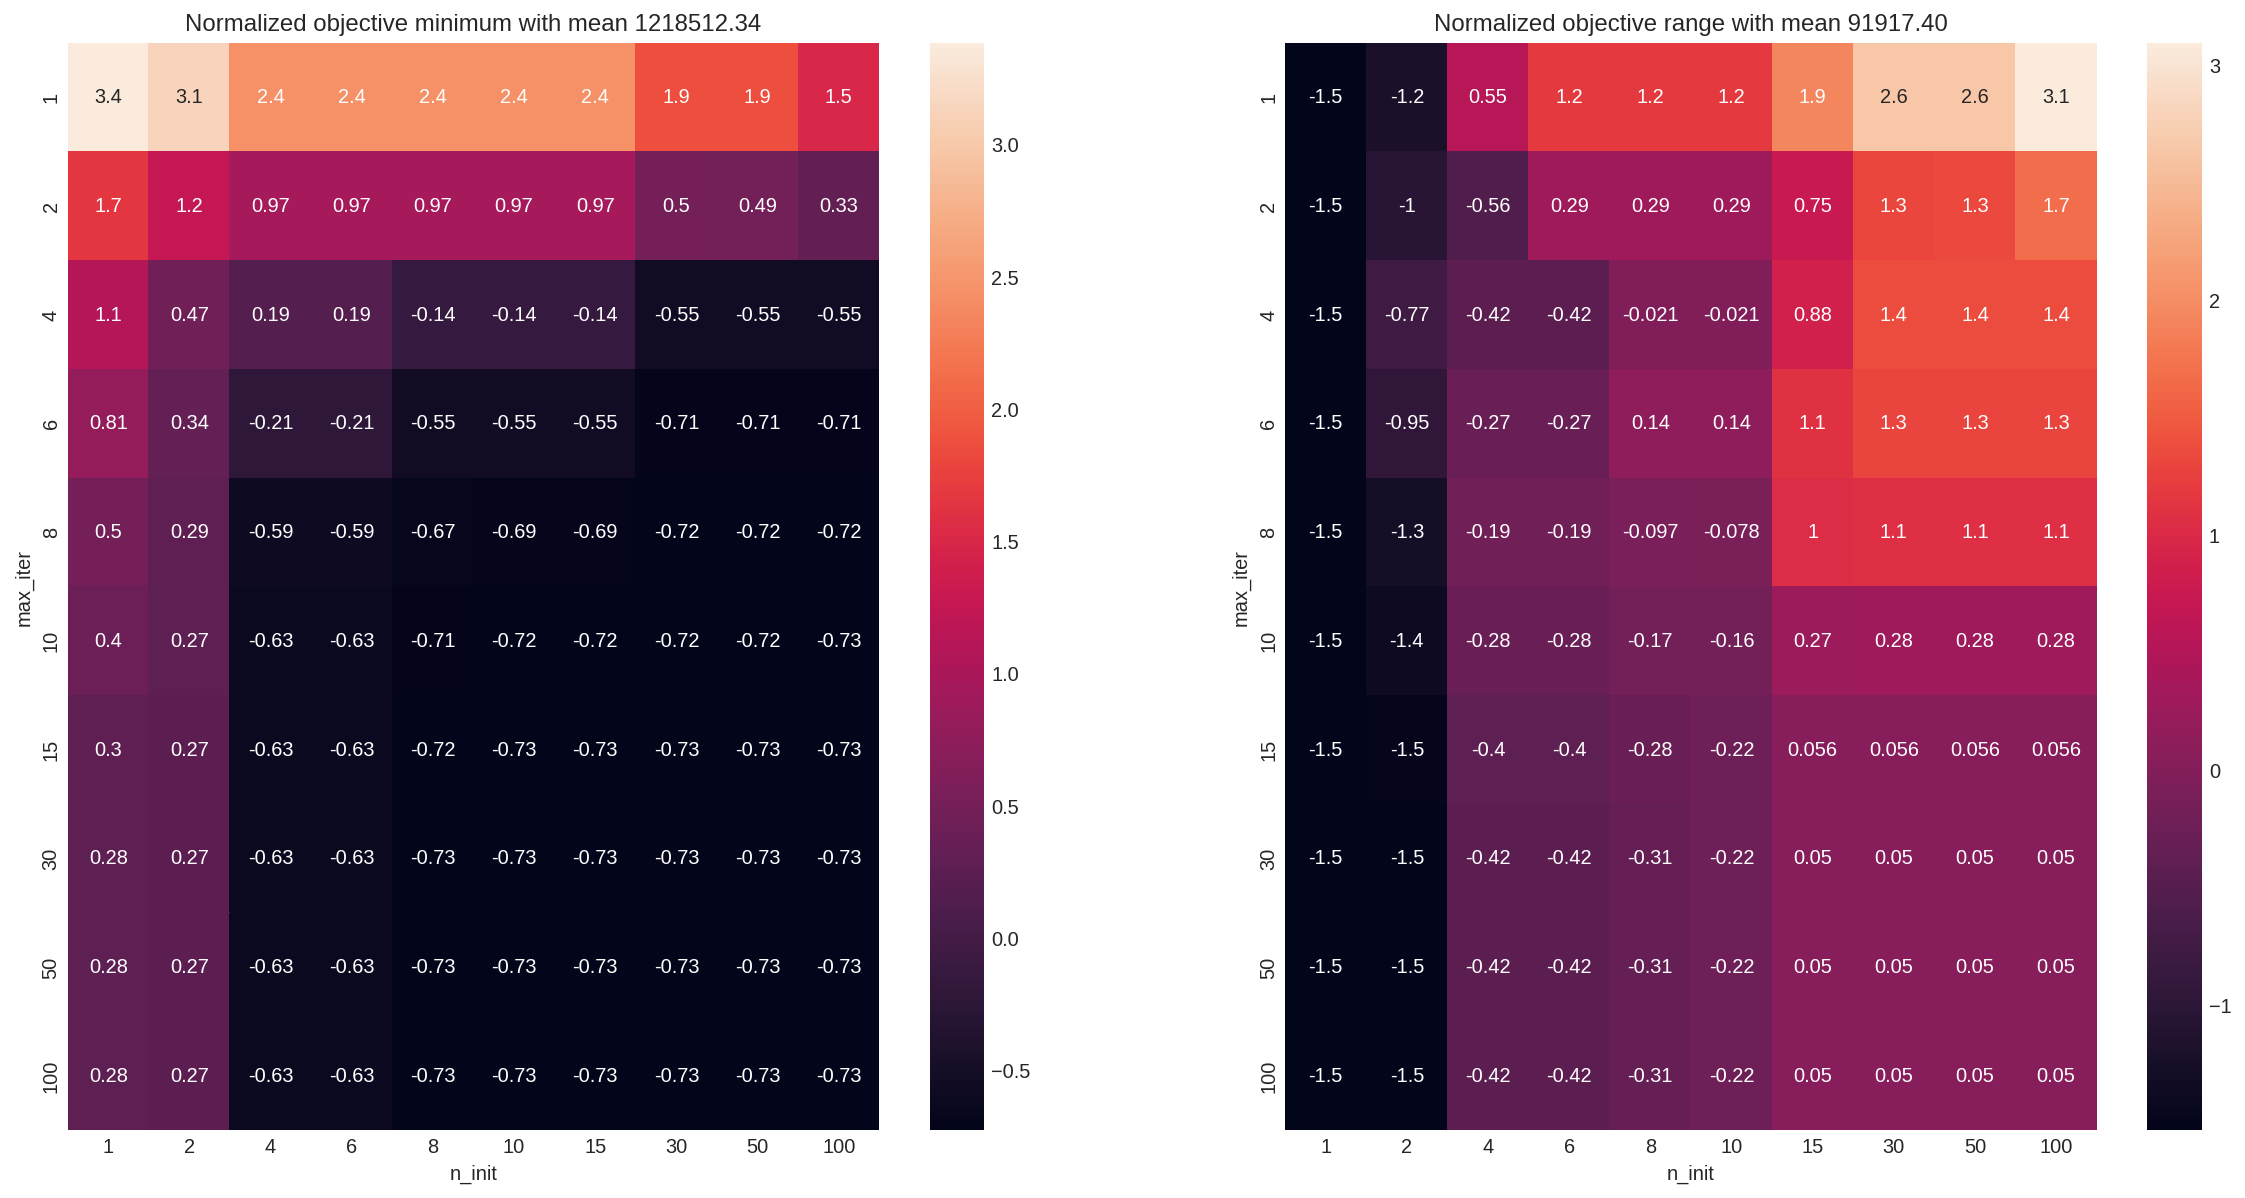

In [49]:
mins = np.array(mins)
ranges = np.array(ranges)

# Normalize and exctract averages for graph due to high values
mean_min = np.mean(mins)
scaled_mins = (mins - mean_min) / np.std(mins)
mean_range = np.mean(ranges)
scaled_ranges = (ranges - mean_range) / np.std(ranges)

fig, ax = plt.subplots(1, 2, figsize=(20, 10))

(sns.heatmap(scaled_mins, ax=ax[0], xticklabels=n_inits, yticklabels=max_iters, annot=True)
    .set(xlabel="n_init", ylabel="max_iter", title=f"Normalized objective minimum with mean {mean_min:.2f}"))

(sns.heatmap(scaled_ranges, ax=ax[1], xticklabels=n_inits, yticklabels=max_iters, annot=True)
    .set(xlabel="n_init", ylabel="max_iter", title=f"Normalized objective range with mean {mean_range:.2f}"));

> We can see that objective fully minimized starting from `max_iter=10-15` and from `n_init=8-10`, and minimum range achieved starting from `max_iter=30` and `n_init=15`. So we can conclude that in our case `max_iter=30, n_init=15` optimal in terms of speed and still yeild max quality. 

Now we will use two popular algorithms: hierarchical clustering and $K$-means clustering. These and other algorithms are available in the `scikit-learn` module in the `cluster` submodule. Hierarchical clustering is called `AgglomerativeClustering`, and the $K$-means method is called `KMeans`.

**(0.5 points)** Use each of the two methods: hierarchical clustering and KMeans. Get the `X` array partition into 10 clusters.

- Note that `AgglomerativeClustering` does not have a `predict` method, so you can either use the `fit_predict` method or use the `fit` method and then look at the `labels_` attribute of the class instance.
- Kmeans performs multiple runs (default 10) with random centers and then returns the best partition in terms of average distance within the clusters. You can increase the number of runs to improve the quality of predictions in the `i_init` parameter.

In [50]:
from sklearn.cluster import AgglomerativeClustering, KMeans

hierarchical_labels = AgglomerativeClustering(n_clusters=10).fit_predict(X)
kmeans_labels = KMeans(n_clusters=10, n_init=30).fit_predict(X)

In [51]:
assert hierarchical_labels.shape == (1797,)
assert kmeans_labels.shape == (1797,)

**(0.5 points)** Visualize the centers of clusters obtained by both methods.

AgglomerativeClustering


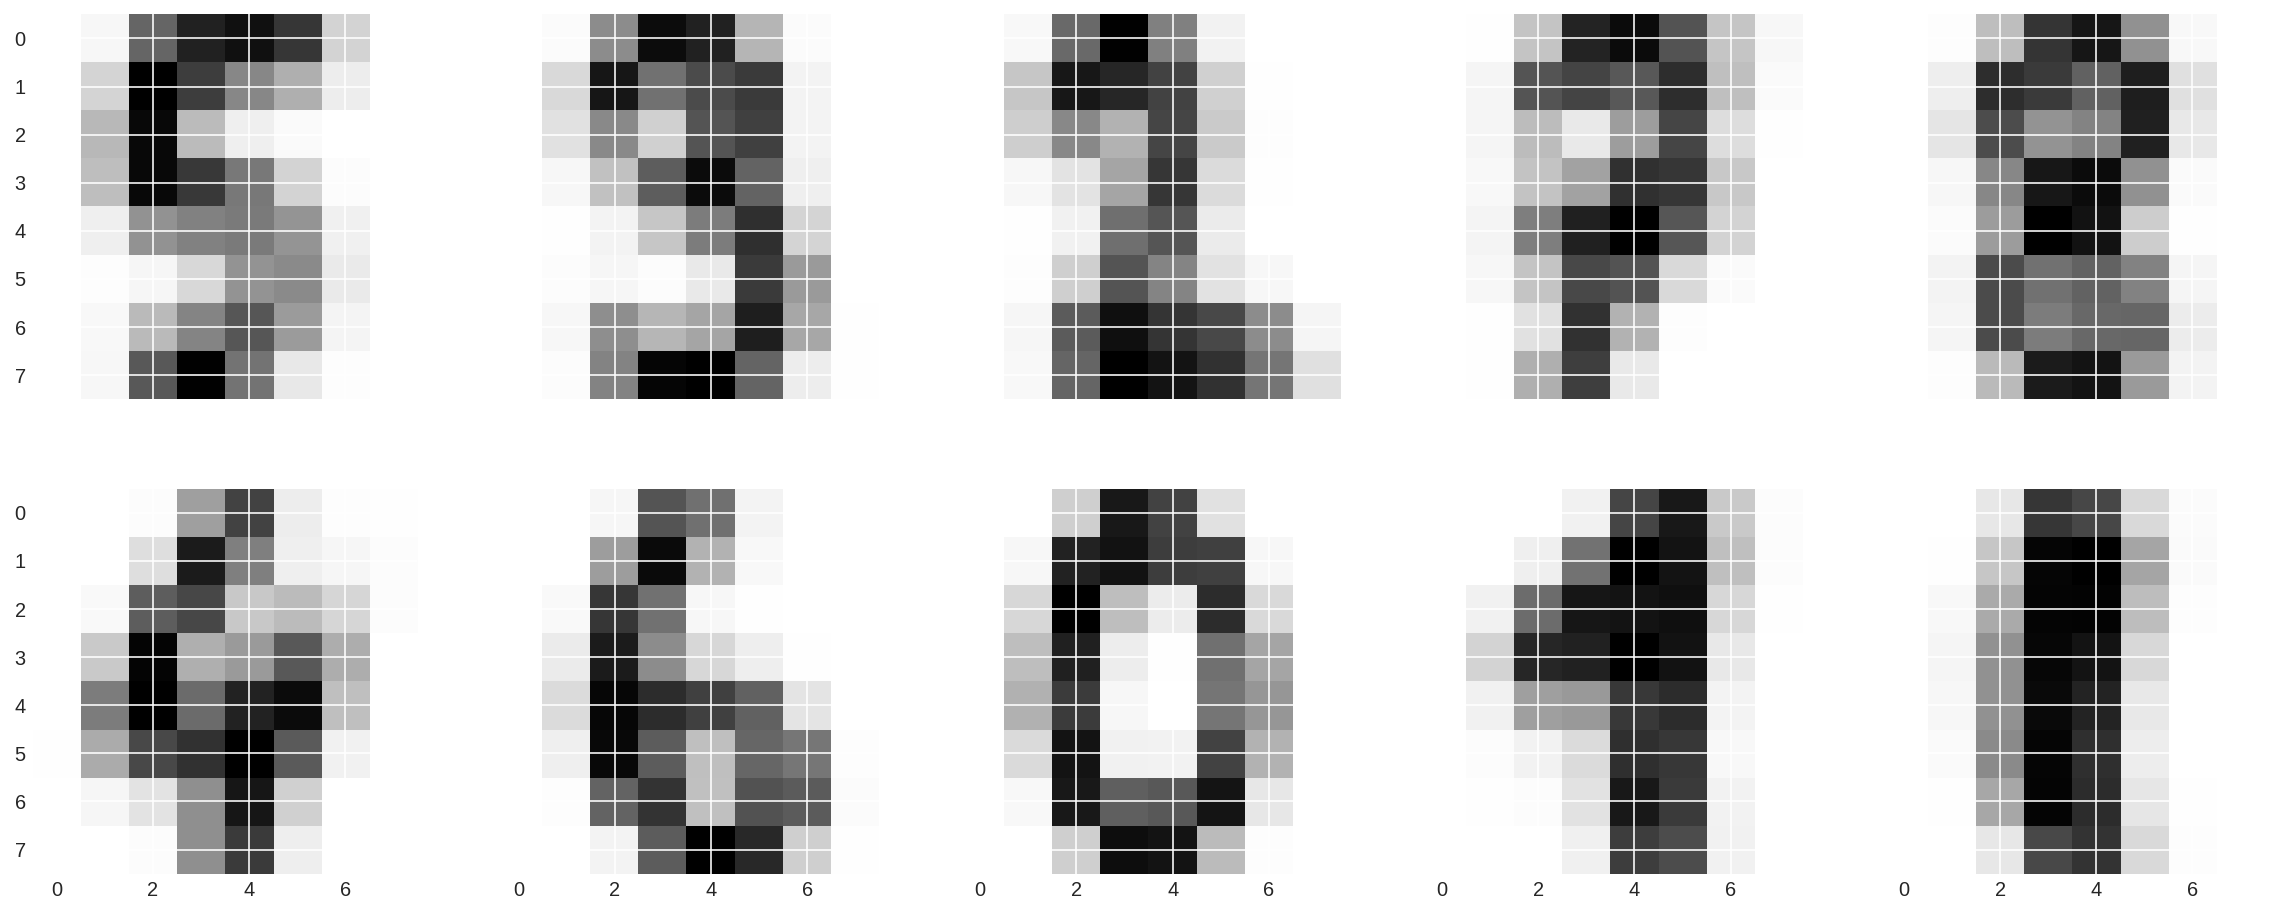

In [52]:
print("AgglomerativeClustering")

hierarchical_centroids = clusters_mean(X, hierarchical_labels)

rows, cols, size = 2, 5, 4
fig, ax = plt.subplots(rows, cols, sharex='col', sharey='row', figsize=(cols * size, rows * size))

for i in range(rows * cols):
    ax[i // cols, i % cols].imshow(hierarchical_centroids[i].reshape((8,8)))

KMeans


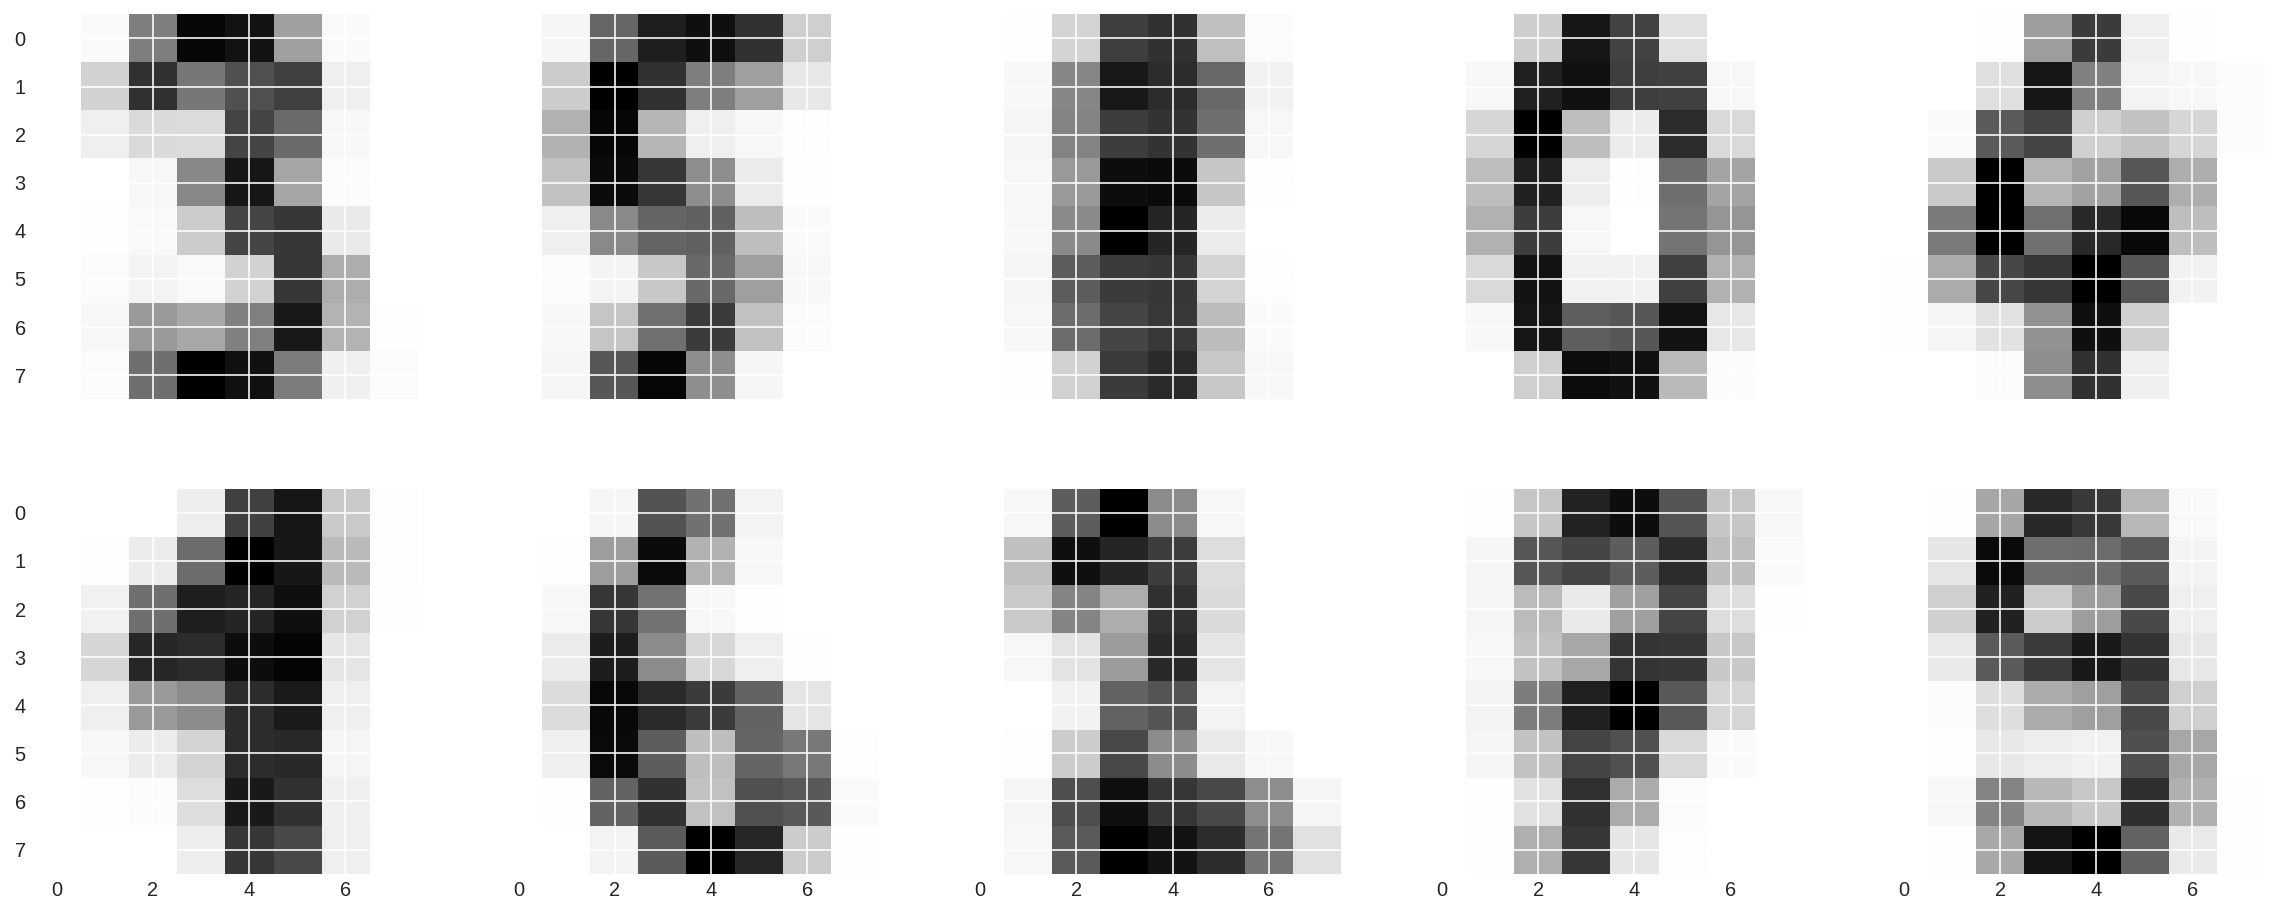

In [53]:
print("KMeans")

kmeans_centroids = clusters_mean(X, kmeans_labels)

rows, cols, size = 2, 5, 4
fig, ax = plt.subplots(rows, cols, sharex='col', sharey='row', figsize=(cols * size, rows * size))

for i in range(rows * cols):
    ax[i // cols, i % cols].imshow(kmeans_centroids[i].reshape((8,8)))

In a situation where the true number of classes is unknown, we can select it by maximazing some metric.

When we can set some distance function between our observations, we can consider the `silhouette` distance as a function of measuring the quality of the clustering. Let's show how it is calculated:

Let $X$ – set of observations, $M \subset X$ – one of the clusters obtained as a result of clustering process, $\rho$ – some metric on $X$. Let's choose one observation $x \in M$. Denote $a(x)$ as the average distance from $x$ to  $x'$ points from the same cluster:
$$
a(x) = \frac{1}{|M| - 1} \sum_{x' \in M,\, x' \ne x} \rho(x,\, x')
$$

Denote $b(x)$ as minimun of average distances from $x$ to $x''$ from some other cluster $N$:
$$
b(x) = \min_{N \ne M} \frac{1}{|N|} \sum_{x'' \in N} \rho(x,\, x'')
$$

The silhouette is difference between a(x) and b(x), normalized to $[-1, \, 1]$ and averaged over all observations:
$$
\frac{1}{|X|} \sum_{x \in X} \frac{b(x) - a(x)}{\max(a(x),\, b(x))}
$$

The implementation of this metric in the `scikit-learn` is the `silhouette_score` function from the `metrics` submidule.

**(0.75 point)** For each $K$ between 2 and 20 inclusive, partition of the array $X$ into $K$ clusters using both methods. Calculate the silhouette score and visualize it for both methods on the same plot ($K$ on the $x$ axis and silhouette score on the $y$ axis). Sign the axes and make a legend.

In [54]:
from sklearn.metrics import silhouette_score, v_measure_score

kmeans_silhouette_score = []
hierarchical_silhouette_score = []

kmeans_vmeasure_score = []
hierarchical_vmeasure_score = []

# collect the scores by fitting and predicting
for k in trange(2, 21):
    hierarchical_labels = AgglomerativeClustering(n_clusters=k).fit_predict(X)
    hierarchical_silhouette_score.append(silhouette_score(X, hierarchical_labels))
    hierarchical_vmeasure_score.append(v_measure_score(y, hierarchical_labels))

    kmeans_labels = KMeans(n_clusters=k, n_init=30).fit_predict(X)
    kmeans_silhouette_score.append(silhouette_score(X, kmeans_labels))
    kmeans_vmeasure_score.append(v_measure_score(y, kmeans_labels))

  0%|          | 0/19 [00:00<?, ?it/s]

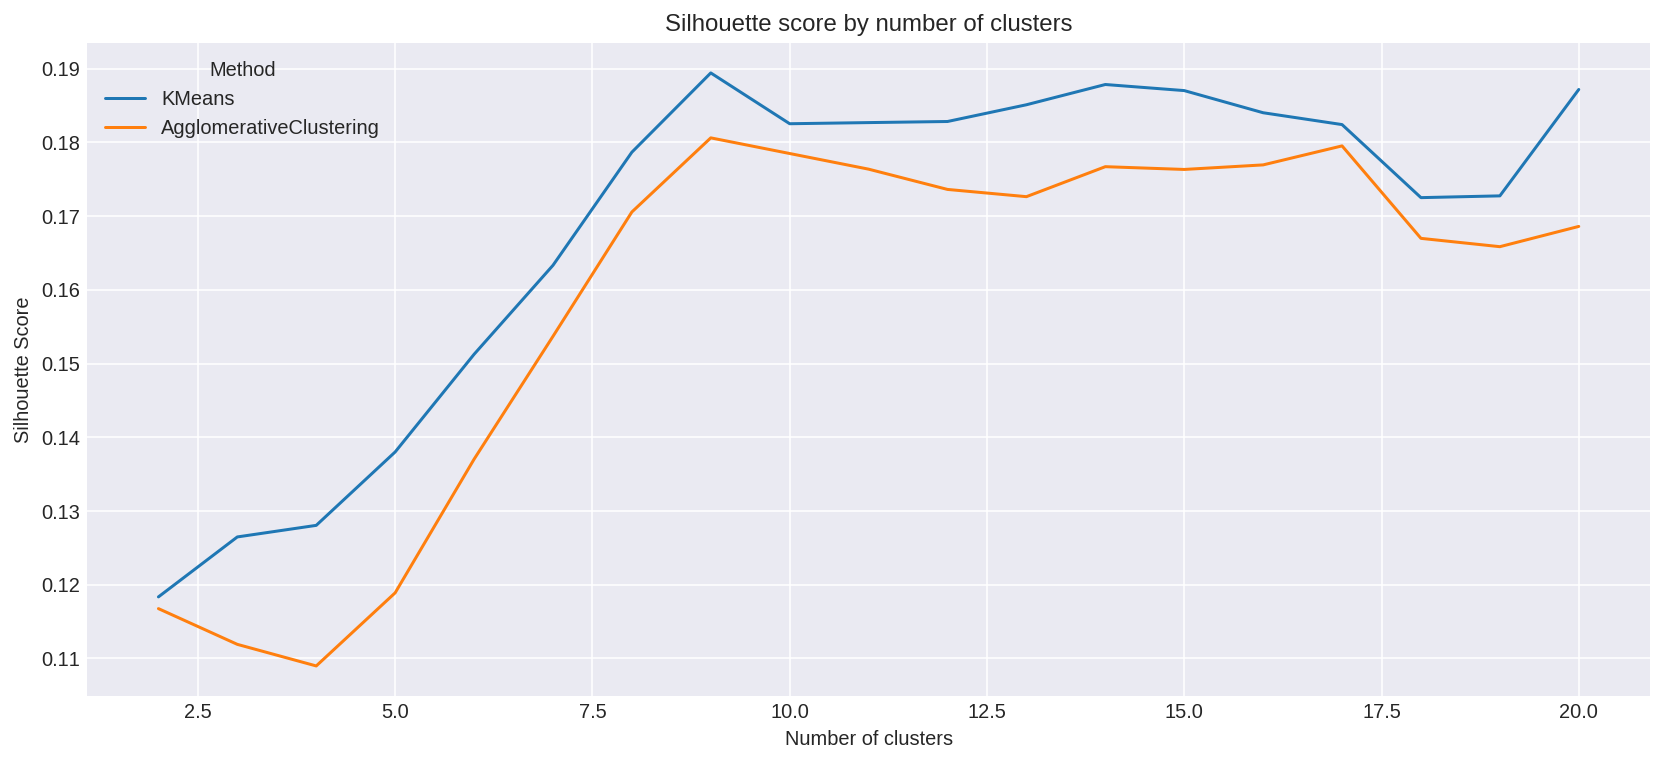

In [55]:
results = pd.DataFrame({
    'KMeans': kmeans_silhouette_score,
    'AgglomerativeClustering': hierarchical_silhouette_score,
    'K': range(2, 21)
})  

data = pd.melt(results, id_vars=['K'], 
               value_vars=['KMeans', 'AgglomerativeClustering'],
               var_name='Method', value_name='silhouette_score')

plt.figure(figsize=(14,6))

(sns.lineplot(data=data, x="K", y="silhouette_score", hue="Method")
    .set(xlabel="Number of clusters", ylabel="Silhouette Score",
         title="Silhouette score by number of clusters"));

When we know the true clustering labels, the clustering result can be compared to them using measures such as `homogeneity`, `completeness` and their harmonic mean - $V$-score. The definitions of these quantities are rather bulky and are based on the [entropy of the probability distribution](https://ru.wikipedia.org/wiki/Информационная_энтропия). Details are given in [this article](http://aclweb.org/anthology/D/D07/D07-1043.pdf). In practice, it's enough to know that `homogeneity`, `completeness` and $V$-score are in the range from 0 and 1, and the more, the better.

Since we know what digit each image is (`y` array), we can compare the clustering results to it using the measures listed above.

**(0.5 points)** Repeat the previous task using $V$-measure instead of silhouette.

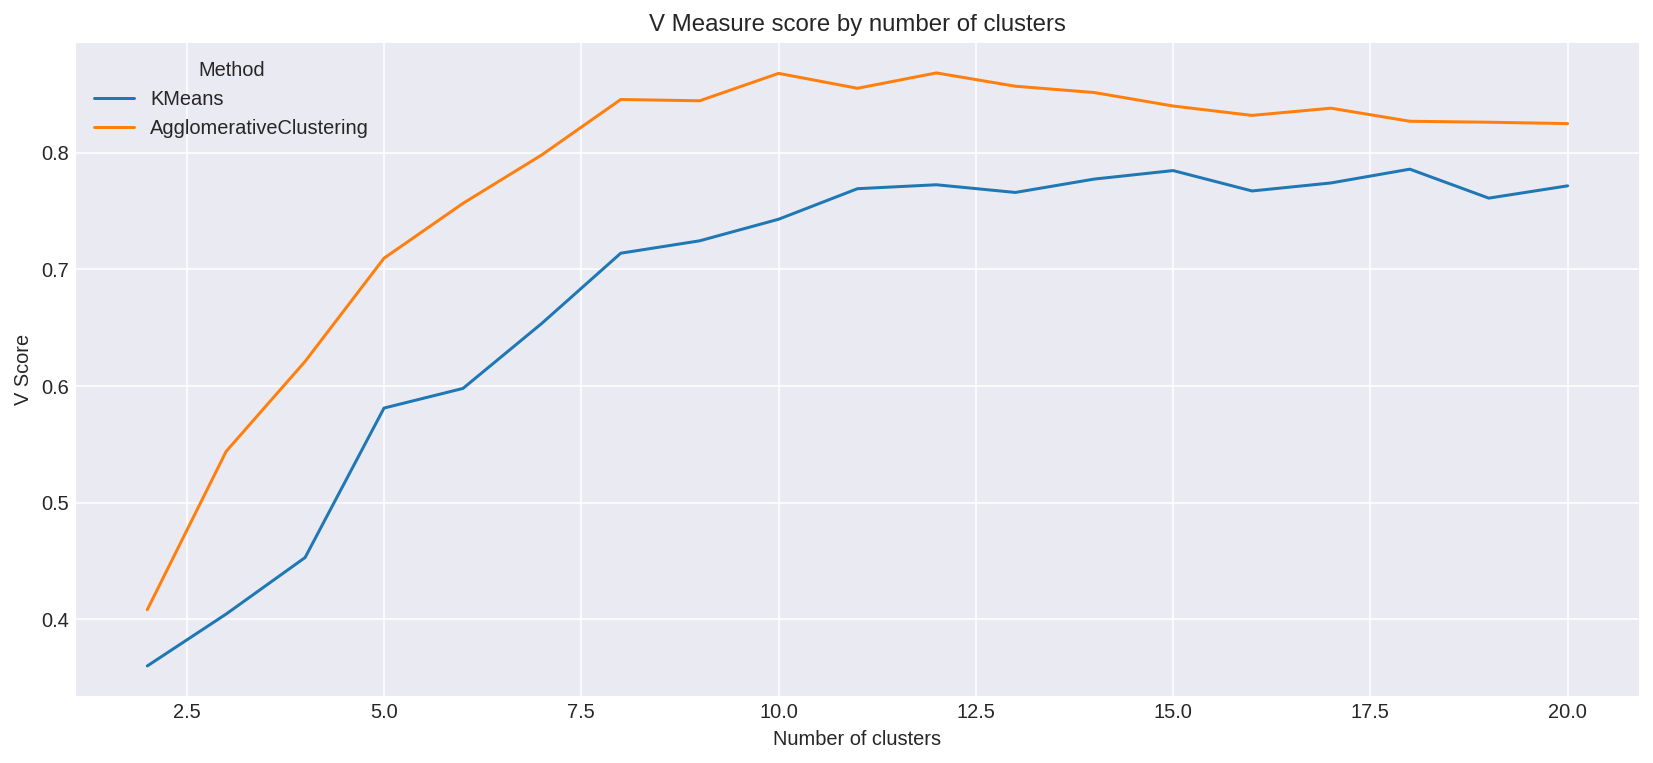

In [56]:
results = pd.DataFrame({
    'KMeans': kmeans_vmeasure_score,
    'AgglomerativeClustering': hierarchical_vmeasure_score,
    'K': range(2, 21)
})  

data = pd.melt(results, id_vars=['K'], 
               value_vars=['KMeans', 'AgglomerativeClustering'],
               var_name='Method', value_name='v_measure_score')

plt.figure(figsize=(14,6))

(sns.lineplot(data=data, x="K", y="v_measure_score", hue="Method")
    .set(xlabel="Number of clusters", ylabel="V Score",
         title="V Measure score by number of clusters"));

## 3. Feature space dimensionality reduction

In some cases, especially when there are a large number of features, when not all of them are informative, and some of them are correlated, it can be useful to reduce the dimension of the feature space. This mean that instead of $d$ original features, we will go to $d'\ll d$ new ones. And if earlier our data were presented in the form of an $n×d$ matrix, then it will presented as a $n×d'$.

There are two popular dimensionality reduction approaches:
- select new features from existing features;
- extract the new features by transforming old ones, for example, by making $d'$ different linear combinations of columns of an $n×d$ matrix.

One widely used dimensionality reduction technique is the Singular Value Decomposition (SVD). This method allows you to construct any number $d'\leq d$ of new features in such a way that they are the most informative (in some sense).

The `scikit-learn` module has several implementations of singular value decomposition. We will use the `TruncatedSVD` class from the `decomposition` submodule.

**Note:** The singular value decomposition of the matrix $M$ is usually written as $M=U \Sigma V^{*}$. `TruncatedSVD`, in turn, returns only the $d'$ first columns of the matrix $U$.

**(0.75 point)** Perform a singular value decomposition of the $X$ matrix, leaving 2, 5, 10, 20 features. In each case, perform hierarchical clustering and $K$-Means clustering (take the number of clusters equal to 10). Calculate the silhouette and $V$-score and compare them to corresponding values obtained from the original data.

**Note**: It is not valid to compare the silhouette calculated with different metrics. Even if we use the same metric function when calculating the distance between points in the data, after applying dimensionality reduction or other data transformations, we will (not always) get different silhouette scores. Therefore, after training the clustering algorithm, to compare the result of clustering, you need to calculate the silhouette on the original data.

In [57]:
from sklearn.decomposition import TruncatedSVD

ds = [2, 3, 4, 5, 7, 10, 15, 20]
n_clusters = 10

kmeans_silhouette_score = []
hierarchical_silhouette_score = []

kmeans_vmeasure_score = []
hierarchical_vmeasure_score = []

# collect the scores by fitting and predicting
for d in tqdm(ds):
    Xd = TruncatedSVD(n_components=d).fit_transform(X)
    hierarchical_labels = AgglomerativeClustering(n_clusters=n_clusters).fit_predict(Xd)
    hierarchical_silhouette_score.append(silhouette_score(X, hierarchical_labels))
    hierarchical_vmeasure_score.append(v_measure_score(y, hierarchical_labels))

    kmeans_labels = KMeans(n_clusters=n_clusters, n_init=30).fit_predict(Xd)
    kmeans_silhouette_score.append(silhouette_score(X, kmeans_labels))
    kmeans_vmeasure_score.append(v_measure_score(y, kmeans_labels))

  0%|          | 0/8 [00:00<?, ?it/s]

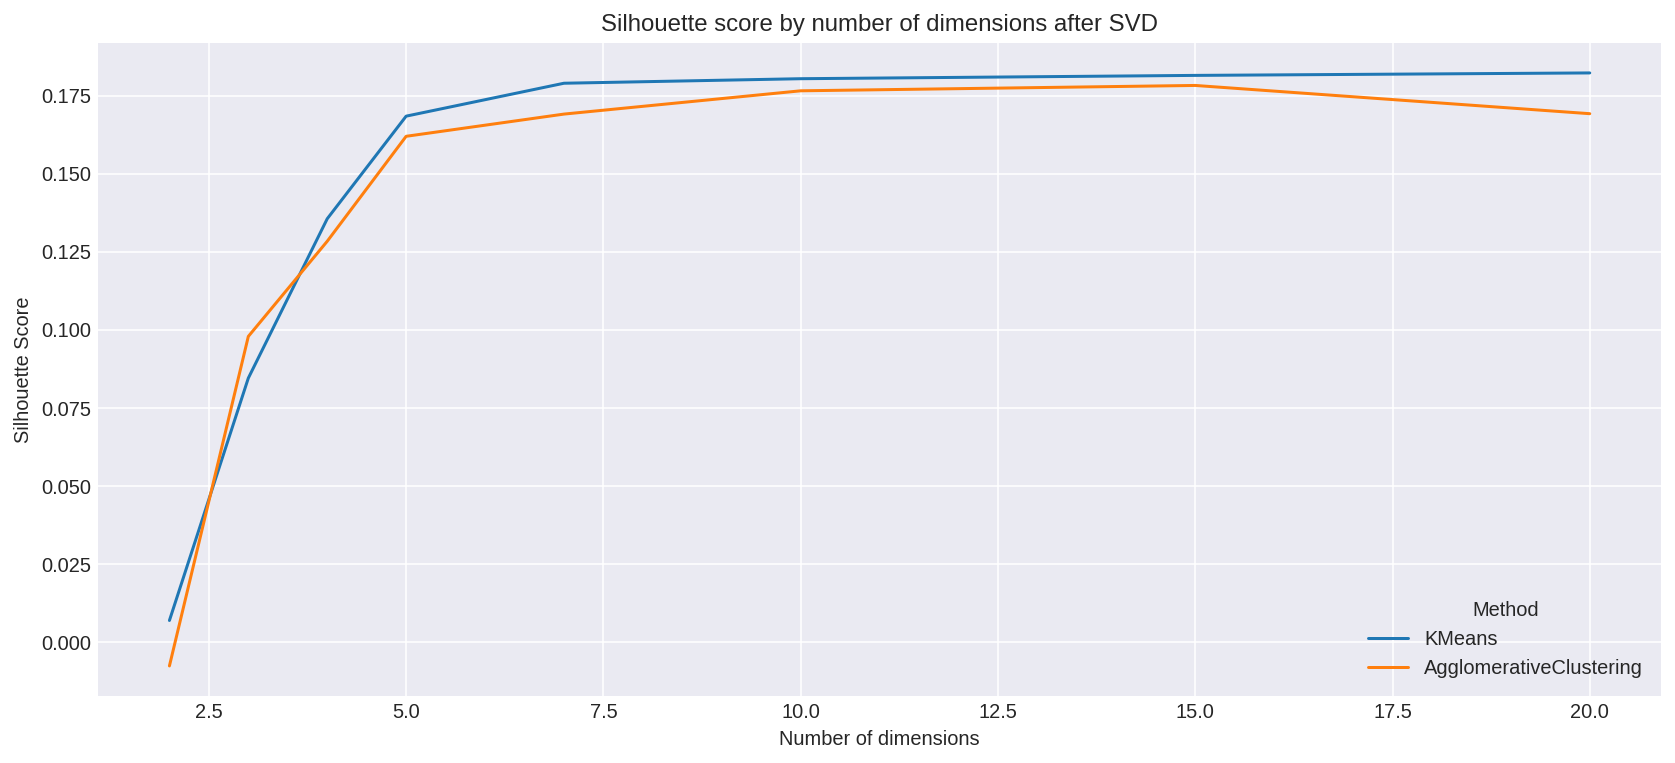

In [58]:
results = pd.DataFrame({
    'KMeans': kmeans_silhouette_score,
    'AgglomerativeClustering': hierarchical_silhouette_score,
    'd': ds
})  

data = pd.melt(results, id_vars=['d'], 
               value_vars=['KMeans', 'AgglomerativeClustering'],
               var_name='Method', value_name='silhouette_score')

plt.figure(figsize=(14,6))

(sns.lineplot(data=data, x="d", y="silhouette_score", hue="Method")
    .set(xlabel="Number of dimensions", ylabel="Silhouette Score",
         title="Silhouette score by number of dimensions after SVD"));

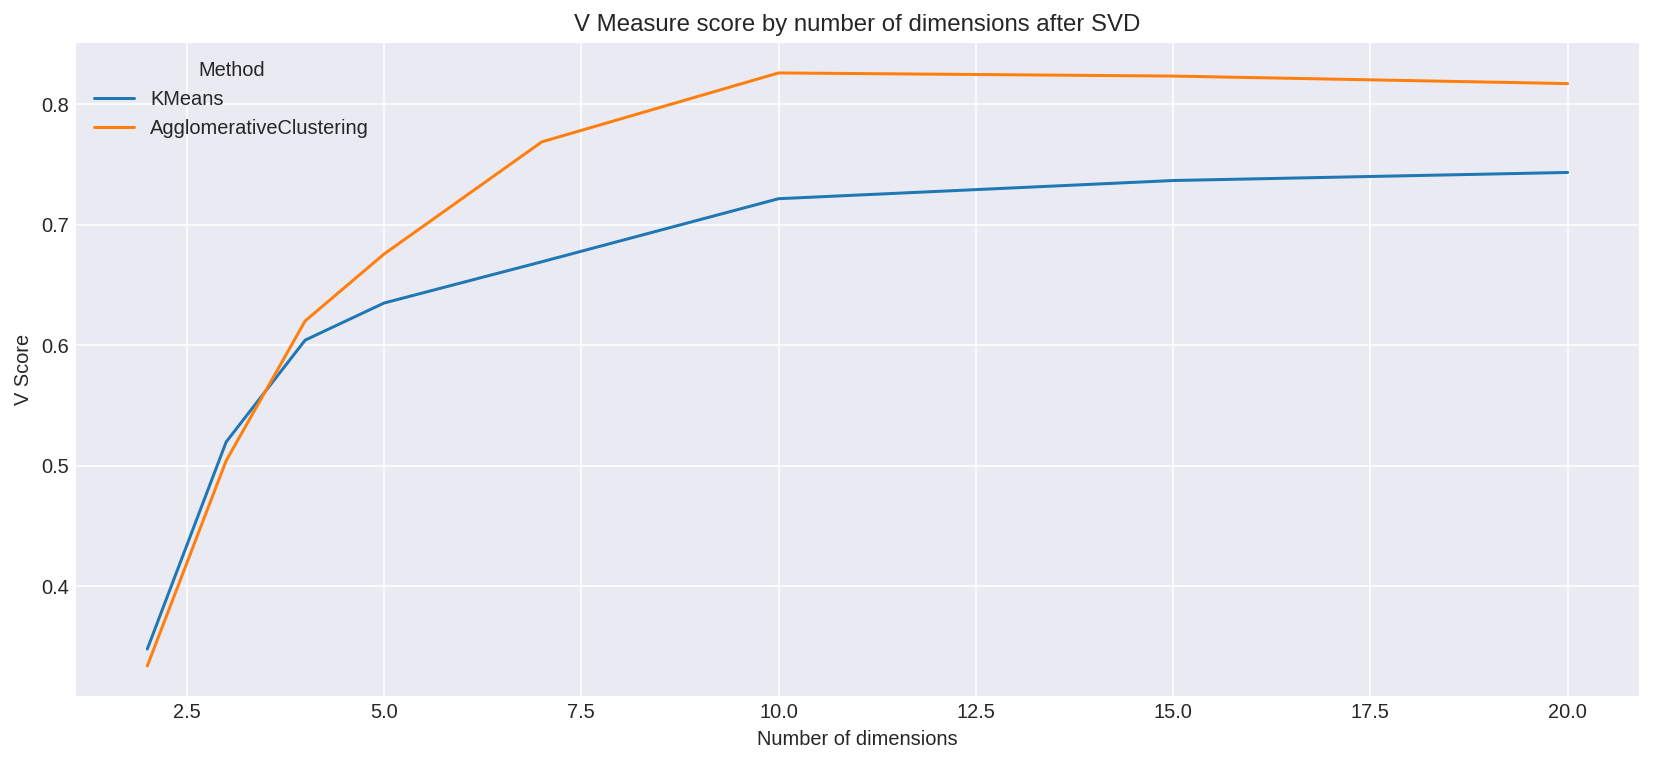

In [59]:
results = pd.DataFrame({
    'KMeans': kmeans_vmeasure_score,
    'AgglomerativeClustering': hierarchical_vmeasure_score,
    'd': ds
})  

data = pd.melt(results, id_vars=['d'], 
               value_vars=['KMeans', 'AgglomerativeClustering'],
               var_name='Method', value_name='v_measure_score')

plt.figure(figsize=(14,6))

(sns.lineplot(data=data, x="d", y="v_measure_score", hue="Method")
    .set(xlabel="Number of dimensions", ylabel="V Score",
         title="V Measure score by number of dimensions after SVD"));

Another popular dimensionality reduction approach that is useful for working with images is t-distributed stochastic neighbor embeddings, abbreviated `tSNE`. Unlike singular value decomposition, this it is non-linear transformation. It's main idea is to map points from a space of dimension `d` to another space of dimension 2 or 3 in such a way that the distances between points are mostly preserved. Mathematical details can be found, for example, [here](https://en.wikipedia.org/wiki/T-distributed_stochastic_neighbor_embedding).

The implementation of `tSNE` in the `scikit-learn` library is the `TSNE` class in the `manifold` submodule.

**Note:** In recent years [UMAP](https://github.com/lmcinnes/umap) is often used istead of `tSNE`. It is a faster algorithm with similar properties. We don't ask you to use `UMAP` because it requires you to install another dependency, the `umap-learn` library. Those who wish can perform the following task using `UMAP`.

**(0.5 points)** Perform a tSNE-transform of the `X` matrix, leaving 2 features. Visualize the obtained data in the form of a scatter plot form: the first feature on the horizontal axis, and the second one the vertical axis. Color the points according to the digits they belong to.

- The `c` parameter in the plt.scatter function is responsible for the color of the points. Pass the true labels to it.

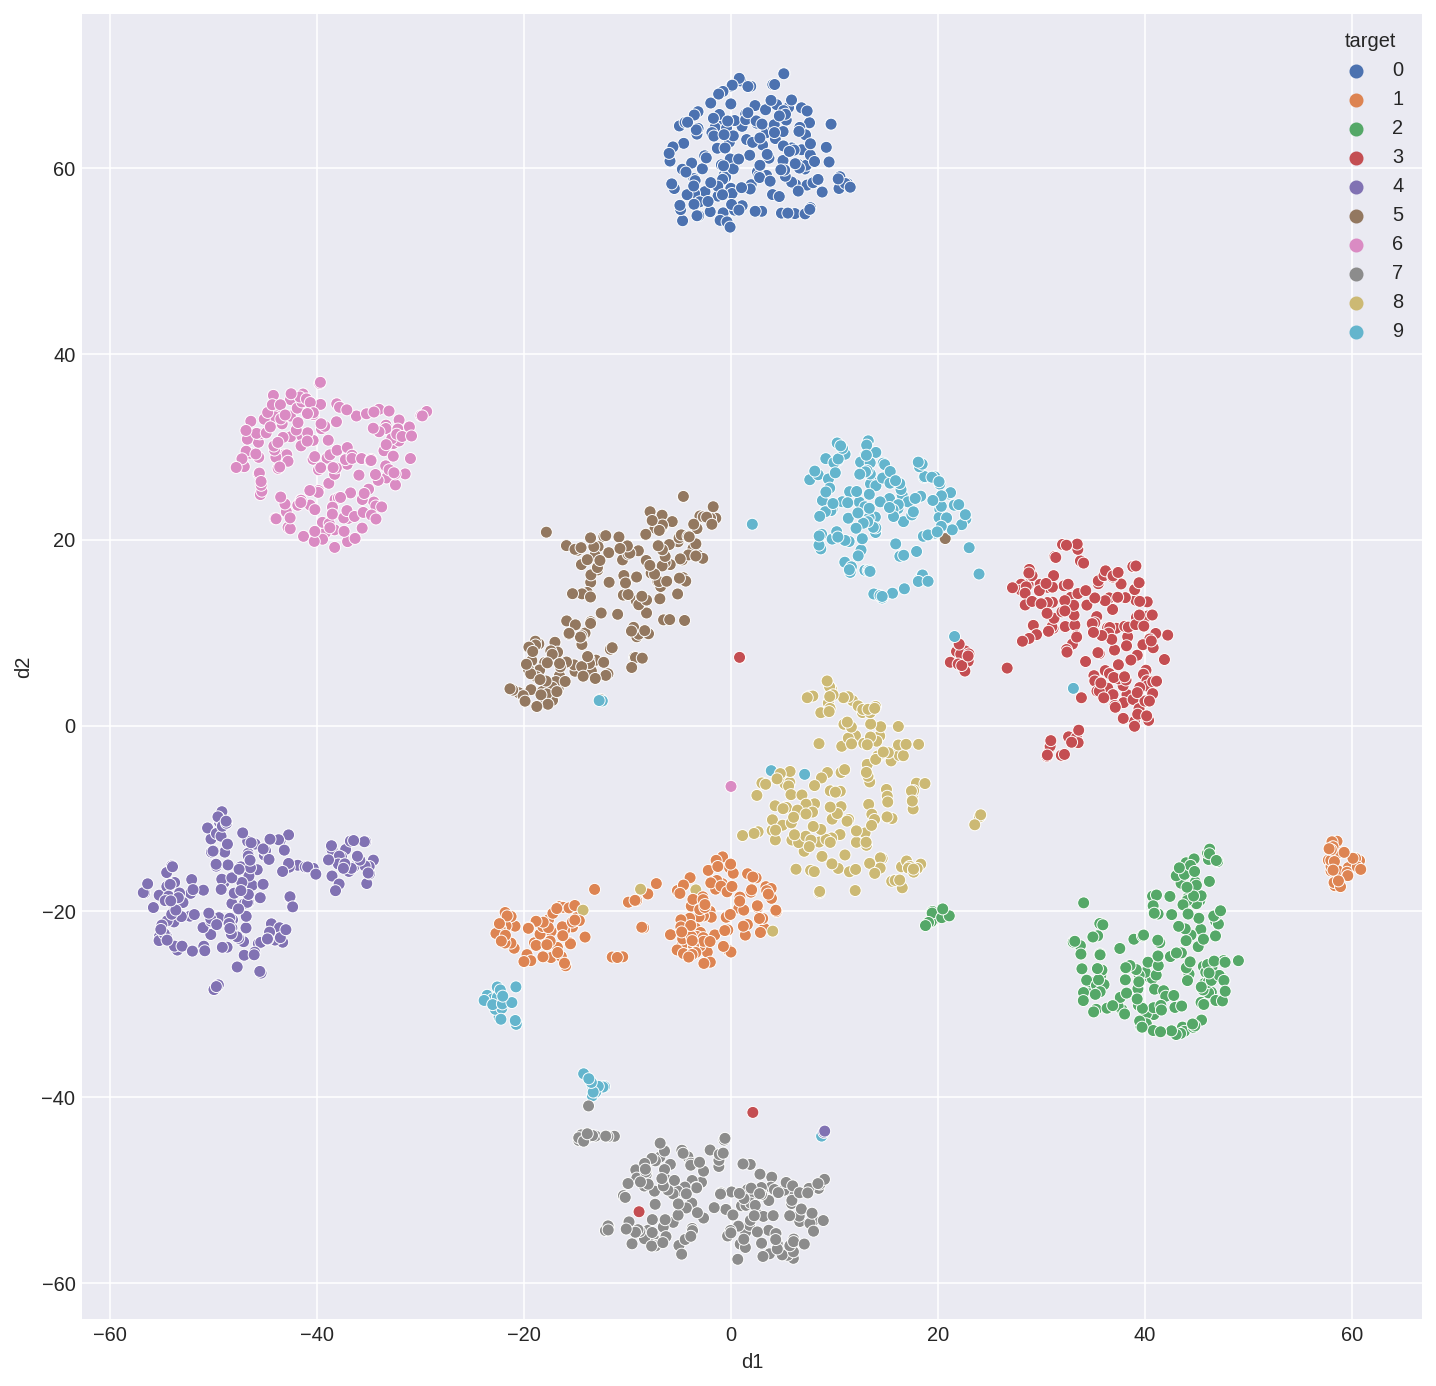

In [60]:
from sklearn.manifold import TSNE

X_2 = TSNE(n_components=2).fit_transform(X)

data = pd.DataFrame(X_2, columns=['d1','d2'])
data['target'] = y

plt.figure(figsize=(12,12))

sns.scatterplot(data=data, x="d1", y="d2", hue='target', palette="deep");

**(0.5 points)** From the data transformed using the tSNE, perform hierarchical clustering and $K$-means clustering (take the number of clusters equal to 10). Calculate the silhouette and the $V$-score and compare them to corresponding values obtained from the original data.

In [61]:
hierarchical_labels = AgglomerativeClustering(n_clusters=10).fit_predict(X_2)
print(
    "AgglomerativeClustering with 10 clusters after tSNE 2d transformation:\n",
    f"{silhouette_score(X, hierarchical_labels):.2f} silhouette score\n",
    f"{v_measure_score(y, hierarchical_labels):.2f} v measure score\n"
)

kmeans_labels = KMeans(n_clusters=10, n_init=30).fit_predict(X_2)
print(
    "KMeans with 10 clusters after tSNE 2d transformation:\n",
    f"{silhouette_score(X, kmeans_labels):.2f} silhouette score\n",
    f"{v_measure_score(y, kmeans_labels):.2f} v measure score"
)

AgglomerativeClustering with 10 clusters after tSNE 2d transformation:
 0.16 silhouette score
 0.92 v measure score

KMeans with 10 clusters after tSNE 2d transformation:
 0.16 silhouette score
 0.91 v measure score


**(0.25 points)** Choose the best partition (in terms of silhouette or $V$-score) and visualize the centers of clusters with images. Did you managed to make each digit correspond to one center of the cluster?

> Best partition is tSNE with AgglomerativeClustering, which results in 0.89 v measure score. Since the score is not 1 - we still have some misclassification. By looking at the tSNE plot we can see that issues can arise when comparing 1 vs 8 and sometimes 9 and 7, which is fair enough. 

tSNE 2d with AgglomerativeClustering


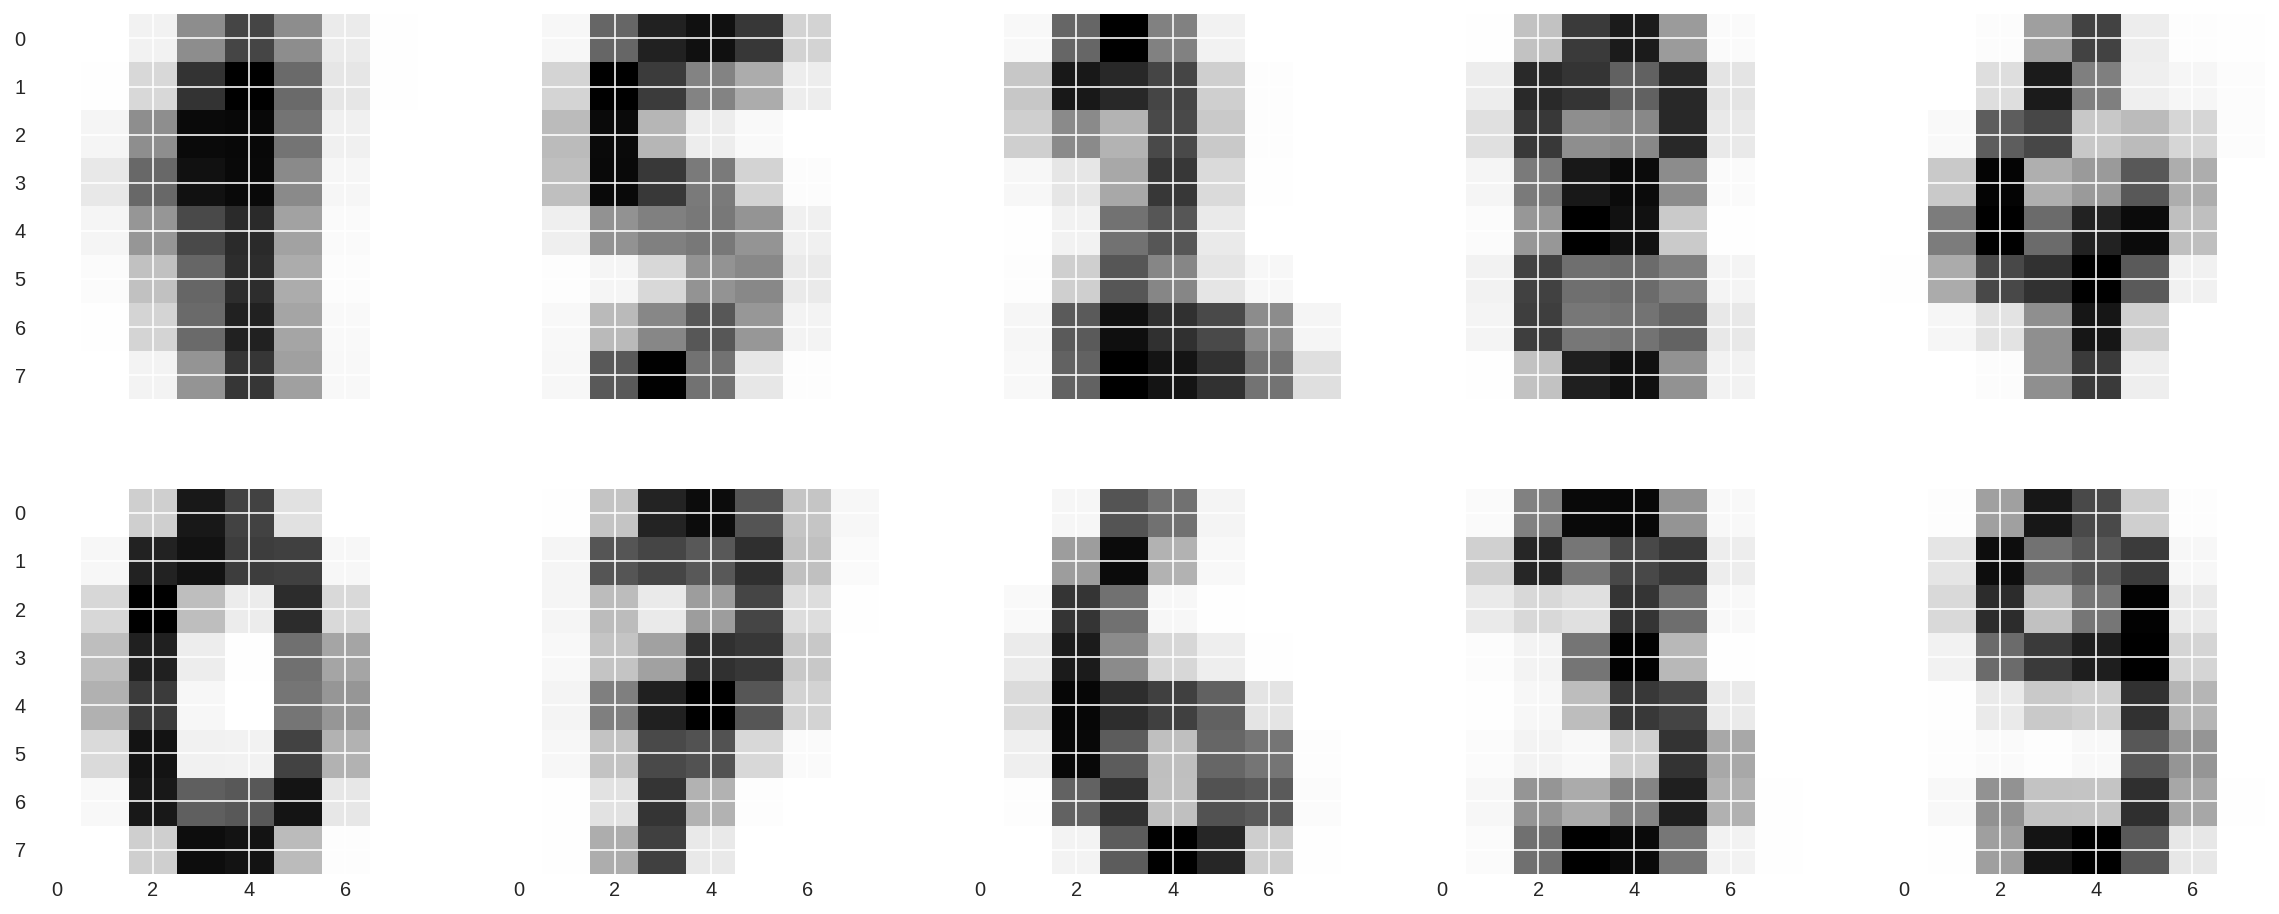

In [62]:
print("tSNE 2d with AgglomerativeClustering")

tsne_agglomerative_centroids = clusters_mean(X, hierarchical_labels)

rows, cols, size = 2, 5, 4
fig, ax = plt.subplots(rows, cols, sharex='col', sharey='row', figsize=(cols * size, rows * size))

for i in range(rows * cols):
    ax[i // cols, i % cols].imshow(tsne_agglomerative_centroids[i].reshape((8,8)))

## 4. Results and bonus part

Write in free form what conclusions you made after completing this assignment. Answer the following questions:

**(0.5 points)** Which algorithm gives more meaningful results - hierarchical clustering or $K$- means clustering. Does it depend on the algorithm settings or on the quality evaluation method?

> Best algorithm in terms of guessing right digits is `AgglomerativeClustering` with `tSNE 2d`, and even without tSNE it showing better result in guessing the right cluster and therefore `v measurement score` is better. 

> But `K-means` showing better results of clustering in terms of `silhouette score`, and therefore can better predict unlabeled clusters. K-means better works without dimensional reduction. More `n_init` you can do - the better.

> So it's definitely depends on quality evalutation method. 

**(0.5 points)** Imagine the situation where after hierarchical clustering, you need to cluster new data in the same way without retraining the model. Suggest a method how you will do it and how you will measure the quality of clustering of new data.

> 1. Find closest points of train set to new data (point in train per point in new data) and use the label of this point as label for the new data.
> 2. Calculate v measure on new data compared to right labels.

**(0.5 points)** Does dimensionality reduction improve clustering results?

> It depends on the method, it can improve `AgglomerativeClustering`, but `KMeans` will work better without it.

**(0.5 points)** How to evaluate the quality of dimensional reduction? Suggest at least 2 options.

> - Calculate loss (MSE) after converting data back to original dimensions
> - Measure loss in variability (sum of eigenvalues)

**(Bonus 2 points)** Load the [MNIST Handwritten Digits](http://yann.lecun.com/exdb/mnist) dataset. You can also do it with `scikit-learn` as explained [here](https://stackoverflow.com/a/60450028). Explore the data and try to cluster it using different approaches. Compare results of these approaches using the silhouette and the $V$-score.

In [63]:
from sklearn.datasets import fetch_openml

X, y = fetch_openml('mnist_784', version=1, return_X_y=True)